In [4]:
%load_ext autoreload
%autoreload 2
%cd ..

/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation


/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%cd cl-adaptation/

[Errno 2] No such file or directory: 'cl-adaptation/'
/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation


/Users/piotr/Documents/studia/mgr/CVLab/cl-teacher-adaptation/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [1]:
import torch

torch.cuda.is_available()

False

In [ ]:
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from src.analysis import core
import re

DEVICE = "cuda"


get_digits = lambda str: int(re.sub(r"\D", "", str))


def is_sign_changed(output_1: torch.Tensor, output_2: torch.Tensor):
    return (output_1.mean(0) * output_2.mean(0)) < 0


def sign_mass(name_path: dict, device="cpu"):
    columns = len(name_path)

    # plt.rcParams.update({"font.size": 16})

    # fig, axs = plt.subplots(1, columns, dpi=100, figsize=(columns * 5, 1 * 5))

    # train_loader, _, test_loader, taskcla = data_factory[0]
    exp_analysis = defaultdict(list)

    for col, (exp_name, exp_path) in enumerate(name_path.items()):
        print(exp_name)
        cfg = core.create_cfg(exp_path)
        # cfg.data.num_workers = 1
        data_factory = core.DataFactory(cfg)
        _, _, test_loader, taskcla = data_factory[0]
        model_factory = core.ModelFactory(cfg, exp_path, device=device)

        for task_idx, ckpt in enumerate(sorted(model_factory.ckpts)):
            assert task_idx == get_digits(ckpt.name)
            if task_idx == 0:
                model = model_factory.create_model(
                    task=task_idx, num_classes=taskcla[1]
                )
                weights = model.heads[-1].weight
                outs_0 = core.get_activations(model.model, test_loader, device=device)
                continue

            model = model_factory.create_model(task=task_idx, num_classes=taskcla[1])
            outs = core.get_activations(model.model, test_loader, device=device)
            labels_signs = {}
            for label in outs_0.keys():
                d_changed = is_sign_changed(outs_0[label], outs[label])
                labels_signs[label] = d_changed
                # print(d_changed.sum())

            sorted_signs = torch.stack(
                [value for key, value in sorted(labels_signs.items())]
            )

            changed_mass = (
                sorted_signs * weights.abs() / weights.abs().sum(1).unsqueeze(1)
            ).sum(1)
            exp_analysis[exp_name].append(changed_mass.detach().cpu())
            # print(
            #     f"{changed_mass.mean().item()=:.2f} {changed_mass.min().item()=:.2f} {changed_mass.max().item()=:.2f}"
            # )
    return exp_analysis

In [5]:
from pathlib import Path

# p = Path("models/cifar100_5/resnet34")
p = Path("models/cifar100_5/convnext")
expname_path = {}
for dir in p.iterdir():
    for i in dir.iterdir():
        path = i.readlink()
        exp_name = "_".join(i.parts[2:])
        expname_path[exp_name] = path

In [6]:
expname_path

{'convnext_finetuning_reg': PosixPath('results/2024/04.24/13-34-44/0/cifar100_fixed_finetuning'),
 'convnext_finetuning_noreg': PosixPath('results/2024/04.17/18-12-39/0/cifar100_fixed_finetuning_final_checkpoint'),
 'convnext_ewc_reg': PosixPath('results/2024/04.24/13-34-32/4/cifar100_fixed_ewc'),
 'convnext_ewc_noreg': PosixPath('results/2024/04.22/23-58-48/0/cifar100_fixed_ewc_final_checkpoint'),
 'convnext_lwf_reg': PosixPath('results/2024/04.24/13-35-04/0/cifar100_fixed_lwf'),
 'convnext_lwf_noreg': PosixPath('results/2024/04.27/10-23-48/0/cifar100_fixed_lwf'),
 'convnext_replay_reg': PosixPath('results/2024/04.24/13-34-32/2/cifar100_fixed_finetuning'),
 'convnext_replay_noreg': PosixPath('results/2024/04.17/18-12-39/1/cifar100_fixed_finetuning_final_checkpoint')}

In [ ]:
{
    "convnext_finetuning_reg": "results/2024/04.24/13-34-44/0/cifar100_fixed_finetuning",
    "convnext_finetuning_noreg": "results/2024/04.17/18-12-39/0/cifar100_fixed_finetuning_final_checkpoint",
    "convnext_ewc_reg": "results/2024/04.24/13-34-32/4/cifar100_fixed_ewc",
    "convnext_ewc_noreg": "results/2024/04.22/23-58-48/0/cifar100_fixed_ewc_final_checkpoint",
    "convnext_lwf_reg": "results/2024/04.24/13-35-04/0/cifar100_fixed_lwf",
    "convnext_lwf_noreg": "results/2024/04.27/10-23-48/0/cifar100_fixed_lwf",
    "convnext_replay_reg": "results/2024/04.24/13-34-32/2/cifar100_fixed_finetuning",
    "convnext_replay_noreg": "results/2024/04.17/18-12-39/1/cifar100_fixed_finetuning_final_checkpoint",
}

In [ ]:
finetuning_exps = {
    # "resnet34_finetuning_reg": "results/2024/04.24/13-35-10/0/cifar100_fixed_finetuning",
    "resnet34_finetuning_noreg": "results/2024/04.17/18-13-25/0/cifar100_fixed_finetuning_final_checkpoint",
}

In [ ]:
exp_analysis = sign_mass(expname_path, DEVICE)
# exp_analysis = sign_mass(
#     dict(filter(lambda x: "finetuning" in x[0], expname_path.items())), DEVICE
# )

In [5]:
exp_analysis = torch.load("exp_analysis.pkl")

In [79]:
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.cm import get_cmap

cmap = get_cmap("Set3")
colors = [cmap(0), cmap(2)]

mpl.rcParams["text.usetex"] = False
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
nice_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "Times New Roman",
    "font.size": 20,
    "lines.linewidth": 3,
}

save_fig_opt = {
    "dpi": 800,
    "transparent": True,
    "bbox_inches": "tight",
    "pad_inches": 0,
}

mpl.rcParams.update(nice_fonts)


method_mapping = {
    "finetuning": "Finetuning",
    "replay": "Finetuning + exemplars",
    "ewc": "EWC",
    "lwf": "LWF",
}
reg_mapping = {
    "reg": "Regularization",
    "noreg": "No regularization",
}

/var/folders/4_/s_rxdxsd00j5rpk8jz76d7mh0000gn/T/ipykernel_2924/3145798691.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("Set3")


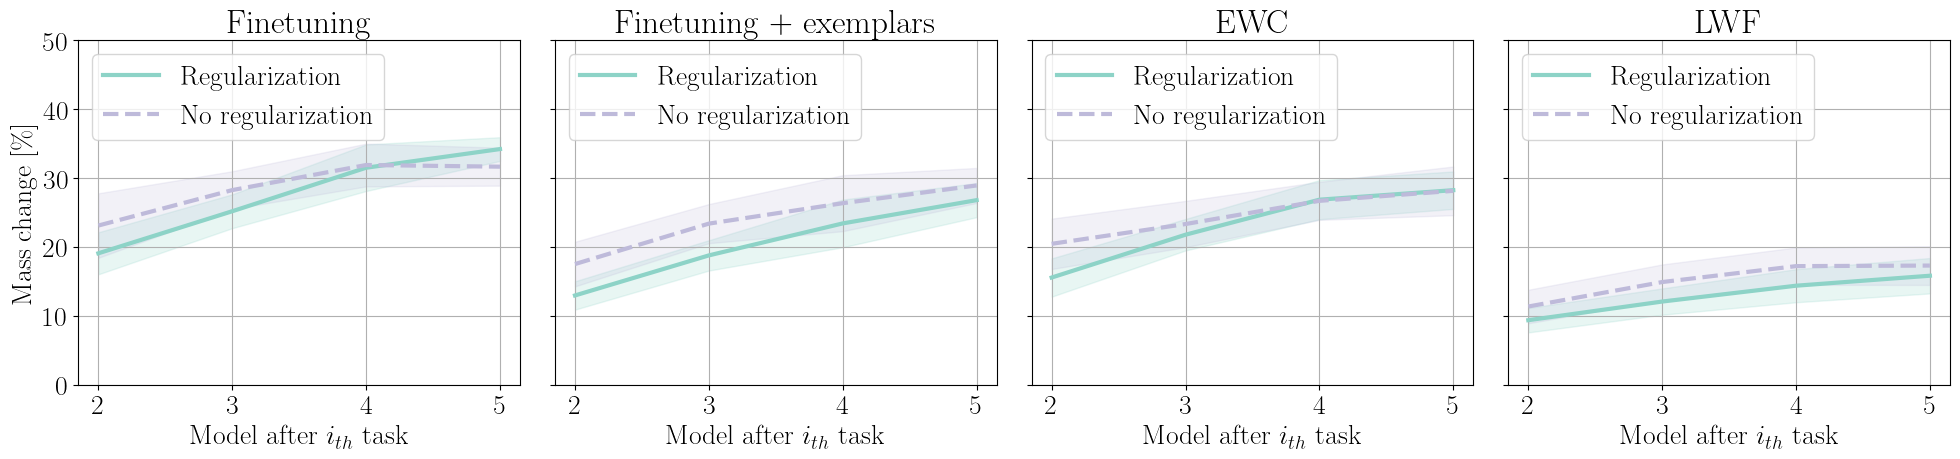

In [85]:
def plt_subplots(exp_analysis):
    methods_pattern = re.compile(r"^.*_(.*)_")
    # methods = set([methods_pattern.match(key).group(1) for key in exp_analysis.keys()])
    methods = ["finetuning", "replay", "ewc", "lwf"]
    fig, axs = plt.subplots(1, len(methods), figsize=(20, 5))
    if len(methods) == 1:
        axs = [axs]

    for i, method in enumerate(methods):
        exp_names = [exp_name for exp_name in exp_analysis.keys() if method in exp_name]
        for name in exp_names:
            arr = (
                np.array([task_a.detach().cpu() for task_a in exp_analysis[name]]) * 100
            )
            *net_name, method_name, is_reg_name = name.split("_")
            color_idx = list(reg_mapping.keys()).index(is_reg_name)
            steps = range(2, arr.shape[0] + 2)
            axs[i].plot(
                steps,
                arr.mean(1),
                "--" if color_idx == 1 else "-",
                label=reg_mapping[is_reg_name],
                color=colors[color_idx],
            )
            axs[i].fill_between(
                steps,
                arr.mean(1) - arr.std(1),
                arr.mean(1) + arr.std(1),
                # color="gray",
                alpha=0.2,
                color=colors[color_idx],
            )
            axs[i].set_ylim([0, 50])
            axs[i].set_xticks(steps)
            axs[i].legend(loc="upper left", fancybox=True, shadow=False)
            # axs[i].grid(b=True, which="major", linestyle="-")
            axs[i].grid(which="major", linestyle="-")
            axs[i].set_title(method_mapping[method_name])
        if i == 0:
            axs[i].set_ylabel(r"Mass change [\%]")
        else:
            axs[i].set(ylabel="", yticklabels=[])
        axs[i].set_xlabel(r"Model after $i_{th}$ task")
    fig.tight_layout()
    plt.show()
    fig.savefig("fig.pdf", **save_fig_opt)


plt_subplots(exp_analysis)

In [ ]:
exp_analysis

In [ ]:
torch.save(exp_analysis, "exp_analysis.pkl")

In [ ]:
exp_analysis

In [ ]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({"font.size": 16})
for exp_name, task_analysis in exp_analysis.items():
    arr = np.array([task_a.detach().cpu() for task_a in task_analysis]) * 100
    marker = "o-" if "noreg" in exp_name else "o--"
    steps = list(range(2, len(task_analysis) + 2))
    plt.plot(steps, arr.mean(1), marker, label=exp_name)
    plt.fill_between(
        steps,
        arr.mean(1) - arr.std(1),
        arr.mean(1) + arr.std(1),
        # color="gray",
        alpha=0.2,
    )
plt.legend(loc="upper left", fancybox=True, shadow=False)
plt.grid()
plt.tight_layout()
plt.xticks(steps)
plt.xlabel("Model wytrenowany po i-tym zadaniu")
plt.ylabel("% masy zmiany znaku wag")
# plt.title("Ważona zmiana znaku wektora cech na danych z pierwszego zadania")
plt.ylim(0, 45)

In [ ]:
exp_analysis